# Naver Image Handling

## Process
- Main image color를 불러와서 32x32 resize & convert("RGB")
- CNN 구성 
- Validation 하면서 augmentation 동시에

**1. 32x32 Resize & convert("RGB") : feature 갯수 줄이고, shape[2]을 모두 3으로 맞춰준다**

In [ ]:
import tensorflow as tf
from PIL import Image as pil
from scipy.misc import imread, imresize
import os
from scipy import ndimage
from six.moves import urllib

cwd = os.getcwd()
cwd

In [2]:
# 웹툰 labeling을 위한 dictionary를 만든다.

# Load info
info = pd.read_csv("data_Juno/webtoon_naver_info_by_genres.csv")

# make dict
dic = {}
for i, id in enumerate(info.unique_id):
    dic[id] = i

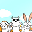

In [4]:
img = pil.open("0_img/main_image_naver/color/103391.png")
img.resize((32,32)).convert("RGB")

In [14]:
path = cwd + "./0_img/main_image_naver/color/"
print(path)
flist = os.listdir(path)
n_class = len(dic)
imgcnt = 0
for f in flist:
    fullpath = os.path.join(path,f)
    currimg = np.asarray(pil.open(fullpath).convert("RGB"))
    img = currimg / 255.
#     print(img.shape)
#     print(imresize(img, (64,64)).shape)
#     print(img)
    img_r = imresize(img, (32,32))
    imgvec = np.reshape(img_r, (1,-1))
    
    # make labels
    id_check = int(f.split(".")[0])
    label = dic[id_check]
    curr_label = np.eye(n_class, n_class)[label:label+1, :]
    if imgcnt == 0:
        totalimg = imgvec
        totallabel = curr_label
    else:
        totalimg = np.concatenate((totalimg, imgvec), axis=0)
        totallabel = np.concatenate((totallabel, curr_label), axis=0)
    print("now: %s finished!!:" % imgcnt, end='\r')
    imgcnt += 1
print ("Total %d images loaded." % (imgcnt))

C:\Users\Juno\Desktop\juno_project\Webtoon-Recommender_System./0_img/main_image_naver/color/


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


Total 745 images loaded.


In [15]:
totalimg.shape, totallabel.shape

((745, 3072), (745, 745))

***.Image Augmentation (Zoom, Rotate)**

In [21]:
# 아예 데이터 늘려버리기
# AUGMENT TRAINING DATA (50배 뻥튀기)
def expand_training_data(images, labels):
    expanded_images = []
    expanded_labels = []
    j = 0 # counter
    for x, y in zip(images, labels):
        j = j+1
        # APPEND ORIGINAL DATA
        expanded_images.append(x)
        expanded_labels.append(y)
        # ASSUME MEDIAN COLOR TO BE BACKGROUND COLOR
        bg_value = np.median(x) # this is regarded as background's value        
        image = np.reshape(x, (32,32,3))
        for i in range(50):
            # ROTATE IMAGE
            angle = np.random.randint(-15,15,1)
            new_img = ndimage.rotate(image,angle,reshape=False, cval=bg_value)
#             # SHIFT IAMGE
#             shift = np.random.randint(-2, 2, 3)
#             new_img_ = ndimage.shift(new_img,shift, cval=bg_value)

            # Zoom
            rg = 0.1
            zoom_factor = np.random.uniform(1.,1.+rg)
            h, w = new_img.shape[:2]
            zh   = int(np.round(zoom_factor * h))
            zw   = int(np.round(zoom_factor * w))
            top  = (zh - h) // 2
            left = (zw - w) // 2
            zoom_tuple = (zoom_factor,) * 2 + (1,) * (new_img.ndim - 2)
            temp = ndimage.zoom(new_img[top:top+zh, left:left+zw], zoom_tuple)
            trim_top  = ((temp.shape[0] - h) // 2)
            trim_left = ((temp.shape[1] - w) // 2)
            new_img = temp[trim_top:trim_top+h, trim_left:trim_left+w]   
            
            # ADD TO THE LIST
            expanded_images.append(np.reshape(new_img, 32*32*3))
            expanded_labels.append(y)
    expanded_train_total_data = np.concatenate((expanded_images, expanded_labels), axis=1)
    np.random.shuffle(expanded_train_total_data)
    return expanded_train_total_data

In [22]:
import warnings
warnings.filterwarnings("ignore")
augmented_total_data = expand_training_data(totalimg, totallabel)

In [23]:
# PRINT FUNCTION
def print_np(x, str):
    print (" TYPE AND SHAPE OF [%18s ] ARE %s and %14s" 
           % (str, type(x), x.shape,))
print_np(augmented_total_data, 'train_total_data')

 TYPE AND SHAPE OF [  train_total_data ] ARE <class 'numpy.ndarray'> and  (37995, 3817)


In [24]:
totalimg_augment = augmented_total_data[:, :-745] / 255.
totallabel_augment = augmented_total_data[:, -745:]

In [25]:
totalimg_augment

array([[0.54117647, 0.54117647, 0.54117647, ..., 0.54509804, 0.54509804,
        0.54509804],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.08235294, 0.09411765,
        0.09411765],
       [0.19607843, 0.19607843, 0.19607843, ..., 0.19607843, 0.19607843,
        0.19607843],
       ...,
       [0.40392157, 0.43529412, 0.43529412, ..., 0.41960784, 0.41960784,
        0.41960784],
       [0.84313725, 0.84313725, 0.84313725, ..., 0.95294118, 0.94901961,
        0.91372549],
       [0.69803922, 0.69803922, 0.69803922, ..., 0.69803922, 0.69803922,
        0.69803922]])

In [26]:
imgcnt = totalimg_augment.shape[0]

In [27]:
# train, test split
def print_shape(string, x):
    print ("Shape of '%s' is %s" % (string, x.shape,))
    
randidx    = np.random.randint(imgcnt, size=imgcnt)
trainidx   = randidx[0:int(3*imgcnt/5)]
testidx    = randidx[int(3*imgcnt/5):imgcnt]
trainimg   = totalimg_augment[trainidx, :]
trainlabel = totallabel_augment[trainidx, :]
testimg    = totalimg_augment[testidx, :]
testlabel  = totallabel_augment[testidx, :]
print_shape("trainimg", trainimg)
print_shape("trainlabel", trainlabel)
print_shape("testimg", testimg)
print_shape("testlabel", testlabel)

Shape of 'trainimg' is (22797, 3072)
Shape of 'trainlabel' is (22797, 745)
Shape of 'testimg' is (15198, 3072)
Shape of 'testlabel' is (15198, 745)


In [28]:
# Save train/test image vector
data_name = "mainset"
imgsize = [32,32]
savepath = cwd + "./0_img/image_vector/" + data_name + ".npz"
np.savez(savepath, trainimg=trainimg, trainlabel=trainlabel
                , testimg=testimg, testlabel=testlabel
                , imgsize=imgsize, categories=dic.values)
print ("SAVED TO [%s]" % (savepath))

SAVED TO [C:\Users\Juno\Desktop\juno_project\Webtoon-Recommender_System./0_img/image_vector/mainset.npz]


In [30]:
# Load them!
cwd = os.getcwd()
data_name = "mainset"
loadpath = cwd + "./0_img/image_vector/" + data_name + ".npz"
l = np.load(loadpath)

# See what's in here
l.files

# Parse data
trainimg_loaded = l['trainimg']
trainlabel_loaded = l['trainlabel']
testimg_loaded = l['testimg']
testlabel_loaded = l['testlabel']

print ("%d train images loaded" % (trainimg_loaded.shape[0]))
print ("%d test images loaded" % (testimg_loaded.shape[0]))
print ("Loaded from to %s" % (loadpath))

22797 train images loaded
15198 test images loaded
Loaded from to C:\Users\Juno\Desktop\juno_project\Webtoon-Recommender_System./0_img/image_vector/mainset.npz


(32, 32, 3)


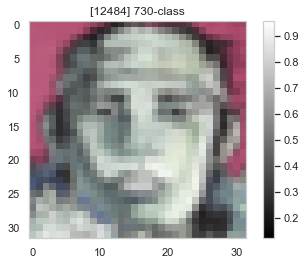

(32, 32, 3)


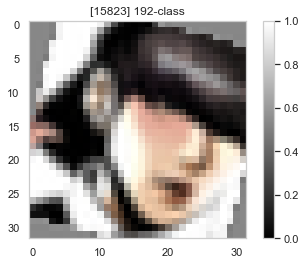

(32, 32, 3)


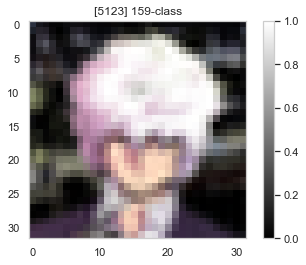

(32, 32, 3)


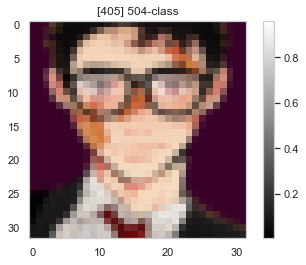

(32, 32, 3)


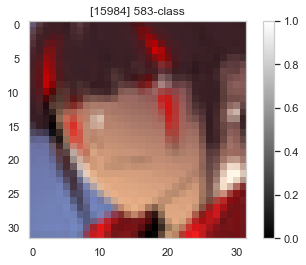

In [32]:
# plot으로 잘 그려지는지 확인해보고~
ntrain_loaded = trainimg_loaded.shape[0]
batch_size = 5
randidx = np.random.randint(ntrain_loaded, size=batch_size)
imgsize = [32,32]
for i in randidx: 
    currimg = np.reshape(trainimg_loaded[i, :], (imgsize[0], imgsize[1], -1))
    print(currimg.shape)
    currlabel_onehot = trainlabel_loaded[i, :]
    currlabel = np.argmax(currlabel_onehot) 
    plt.imshow(currimg, cmap=plt.get_cmap('gray'))
    plt.colorbar()
    plt.grid(False)
    title_string = "[%d] %d-class" % (i, currlabel)
    plt.title(title_string) 
    plt.show()

**2.CNN 구성**

In [33]:
# Define model
n_input = 3072
n_channel = 32 # convolution filter의 갯수
n_classes = 745
n_imgch = 3
x = tf.placeholder(dtype='float', shape=[None, n_input])
y = tf.placeholder(dtype='float', shape=[None, n_classes])

stddev = 0.1
# convolution filters
weights = {
    'c1' : tf.Variable(initial_value=tf.random_normal(shape=[3,3,n_imgch,n_channel], stddev=stddev)),
    'c2' : tf.Variable(initial_value=tf.random_normal(shape=[3,3,n_channel,32], stddev=stddev)),
    'c3' : tf.Variable(initial_value=tf.random_normal(shape=[3,3,32,32], stddev=stddev)),
    'd1' : tf.Variable(initial_value=tf.random_normal(shape=[4*4*32,n_classes], stddev=stddev)),
}
biases = {
    'c1' : tf.Variable(initial_value=tf.random_normal(shape=[n_channel], stddev=stddev)),
    'c2' : tf.Variable(initial_value=tf.random_normal(shape=[32], stddev=stddev)),
    'c3' : tf.Variable(initial_value=tf.random_normal(shape=[32], stddev=stddev)),
    'd1' : tf.Variable(initial_value=tf.random_normal(shape=[n_classes], stddev=stddev)),
}
print("Model is defined!!")

Model is defined!!


In [34]:
# Define Graph
def CNN(_x, _w, _b):
    # Reshape
    _x_r = tf.reshape(_x, shape=[-1,32,32,3])
    # Convolution
    _conv1 = tf.nn.conv2d(_x_r, _w['c1'], strides=[1,1,1,1], padding='SAME') # zero-padding
    # add bias
    _conv2 = tf.nn.bias_add(_conv1, _b['c1'])
    # Passing the ReLU
    _conv3 = tf.nn.relu(_conv2)
    # max pooling
    # non-overlapping
    _pool = tf.nn.max_pool(_conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # 2nd Convolutional Layer
    _second = tf.nn.conv2d(_pool, _w['c2'], strides=[1,1,1,1], padding='SAME')
    _second = tf.nn.bias_add(_second, _b['c2'])
    _second = tf.nn.relu(_second)
    _second = tf.nn.max_pool(_second, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # 3rd Convolutional Layer
    _third = tf.nn.conv2d(_second, _w['c3'], strides=[1,1,1,1], padding='SAME')
    _third = tf.nn.bias_add(_third, _b['c3'])
    _third = tf.nn.relu(_third)
    _third = tf.nn.max_pool(_third, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # fully connected layer, 한 줄로 쫙 편다.
    _dense = tf.reshape(_third, shape=[-1,  _w['d1'].get_shape().as_list()[0]])
    _logit = tf.add(tf.matmul(_dense, _w['d1']),_b['d1'])
    
    # Return to dict type
    _out = {
        'x_r':_x_r, 'conv1':_conv1, 'conv2' : _conv2, 'conv3': _conv3,
        'pool': _pool, 'dense': _dense, 'logit':_logit
    }
    return _out

cnnout = CNN(x, weights, biases)

# cost and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=cnnout['logit']))
optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)
correct = tf.equal(tf.argmax(cnnout['logit'],1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

# initialize
init = tf.global_variables_initializer()
print("Function Ready!!")

Function Ready!!


In [ ]:
# Saver
savedir = "./3_NeuralNet_image/main_image/"
saver = tf.train.Saver(max_to_keep=3) # 최근 3개까지 저장하겠다.
save_step = 4
if not os.path.exists(savedir):
    os.makedirs(savedir)
print("Saver Ready!!")

In [35]:
ntrain = trainimg.shape[0]
nclass = trainlabel.shape[1]
dim    = trainimg.shape[1]
ntest  = testimg.shape[0]
print ("%d TRAIN IMAGES" % (ntrain))
print ("%d TEST IMAGES" % (ntest))
print ("%d DIMENSIONAL INPUT" % (dim))
print ("%d CLASSES" % (nclass))
print (imgsize)
print ("categories: ",dic.values)

22797 TRAIN IMAGES
15198 TEST IMAGES
3072 DIMENSIONAL INPUT
745 CLASSES
[32, 32]
categories:  <built-in method values of dict object at 0x0000021E6C2C7CF0>


In [36]:
# RUN
# PARAMETERS
training_epochs = 50
batch_size      = 100
disp_each       = 1

# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)

# OPTIMIZE
for epoch in range(training_epochs):
    total_batch = int(ntrain/batch_size)
    random_permut = np.random.permutation(ntrain)
    sum_cost = 0
    for i in range(total_batch):
        randidx = random_permut[i*batch_size:min((i+1)*batch_size, ntrain-1)]
        batch_xs = trainimg[randidx,:]
        batch_ys = trainlabel[randidx, :]
#         print(batch_xs.shape, batch_ys.shape)
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys})
        sum_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})
    avg_cost = sum_cost / total_batch
    # DISPLAY
    if (epoch+1) % disp_each == 0 or epoch == training_epochs-1:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
        feeds = {x: batch_xs, y: batch_ys}
        train_acc = sess.run(accuracy, feed_dict=feeds)
        print (" TRAIN ACCURACY: %.3f" % (train_acc))
        feeds = {x: testimg, y: testlabel}
        test_acc = sess.run(accuracy, feed_dict=feeds)
        print (" TEST ACCURACY: %.3f" % (test_acc))

Epoch: 001/050 cost: 2.966025225
 TRAIN ACCURACY: 0.980
 TEST ACCURACY: 0.957
Epoch: 002/050 cost: 0.026884271
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.981
Epoch: 003/050 cost: 0.012303357
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.996
Epoch: 004/050 cost: 0.005322812
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.996
Epoch: 005/050 cost: 0.013713778
 TRAIN ACCURACY: 0.990
 TEST ACCURACY: 0.978
Epoch: 006/050 cost: 0.010351568
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.993
Epoch: 007/050 cost: 0.004569477
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.996
Epoch: 008/050 cost: 0.012677261
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.993
Epoch: 009/050 cost: 0.004827425
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.997
Epoch: 010/050 cost: 0.003179842
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.999
Epoch: 011/050 cost: 0.003476789
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.995
Epoch: 012/050 cost: 0.004641453
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.992
Epoch: 013/050 cost: 0.009603077
 TRAIN ACCURACY: 1.000
 TEST AC

In [37]:
saver = tf.train.Saver()
save_path = saver.save(sess, "./0_img/model.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: ./0_img/model.ckpt
